In [1]:
import pickle as pkl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np


In [2]:
with open('signal.pkl', 'rb') as f:
    signal = pkl.load(f)

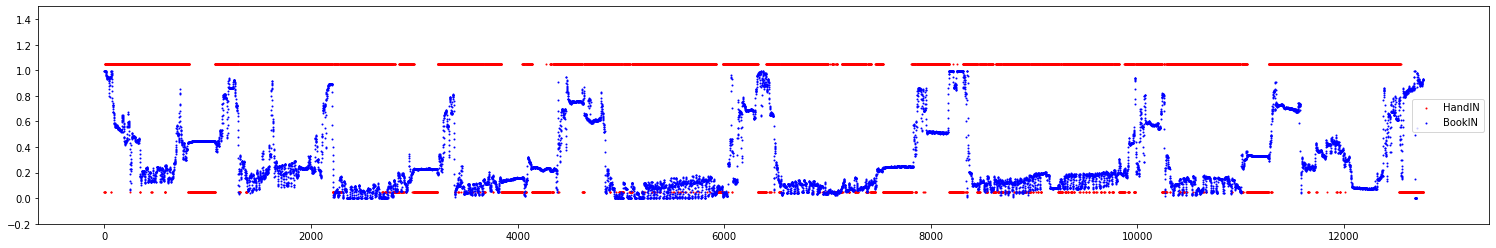

In [3]:
seq_len = len(signal['signal_hand'])
fig = plt.figure(figsize=(26,4))
plt.scatter(np.arange(seq_len), np.array(signal['signal_hand'])+0.05, c='r', s=1, label='HandIN')
plt.scatter(np.arange(seq_len), np.array(signal['signal_book']), c='b', s=1, label='BookIN')
plt.ylim([-0.2, 1.5])
plt.legend(loc='center right')
plt.show()

In [4]:
import cv2

(12769, 1) (12769,)
(12769, 1)


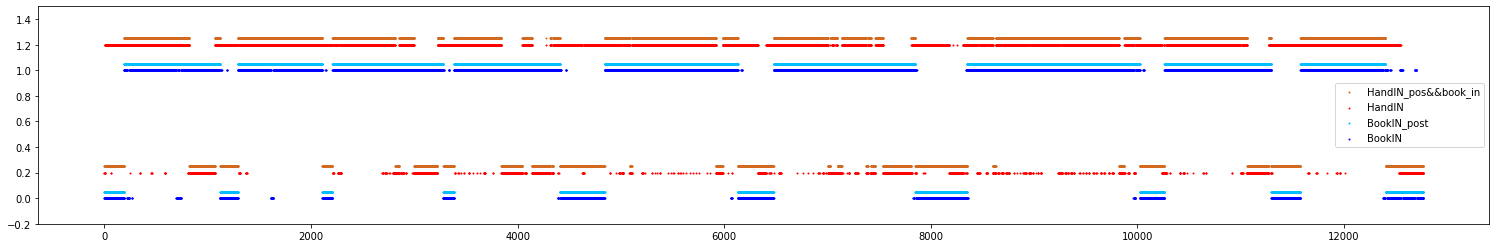

In [5]:
seq_len = len(signal['signal_hand'])
fig = plt.figure(figsize=(26,4))

s_book = np.array(signal['signal_book'])*255
s_book = cv2.medianBlur(s_book.astype(np.uint8), 51).astype(np.float)/255.
s_book = s_book < 0.5
signal_book_v1 = cv2.morphologyEx(s_book.astype(np.uint8), cv2.MORPH_CLOSE, np.ones(31, np.uint8))


print(signal_book_v1.shape, np.array(signal['signal_hand']).shape)
signal_hand_v1 = np.logical_and(np.array(signal['signal_hand']), signal_book_v1.squeeze())
signal_hand_v1 = cv2.morphologyEx(signal_hand_v1.astype(np.uint8), cv2.MORPH_CLOSE, np.ones(15, np.uint8)) # fps=30
print(signal_hand_v1.shape)
plt.scatter(np.arange(seq_len), signal_hand_v1+0.25, c='chocolate', s=1, label='HandIN_pos&&book_in')
plt.scatter(np.arange(seq_len), np.array(signal['signal_hand'])+0.2, c='r', s=1, label='HandIN')



plt.scatter(np.arange(seq_len), signal_book_v1+0.05, c='deepskyblue', s=1, label='BookIN_post')
plt.scatter(np.arange(seq_len), np.array(signal['signal_book'])<0.5, c='b', s=1, label='BookIN')

plt.ylim([-0.2, 1.5])
plt.legend(loc='center right')
plt.show()

{0, 1, -1}
Cut points:  [1122, 2110, 3282, 4410, 6132, 7851, 10024, 11297, 12403]
Start cycle points:  [0, 1122, 2110, 3282, 4410, 6132, 7851, 10024, 11297, 12403]
piece_enter_points:  [191, 1293, 2208, 3385, 4843, 6479, 8351, 10262, 11579]


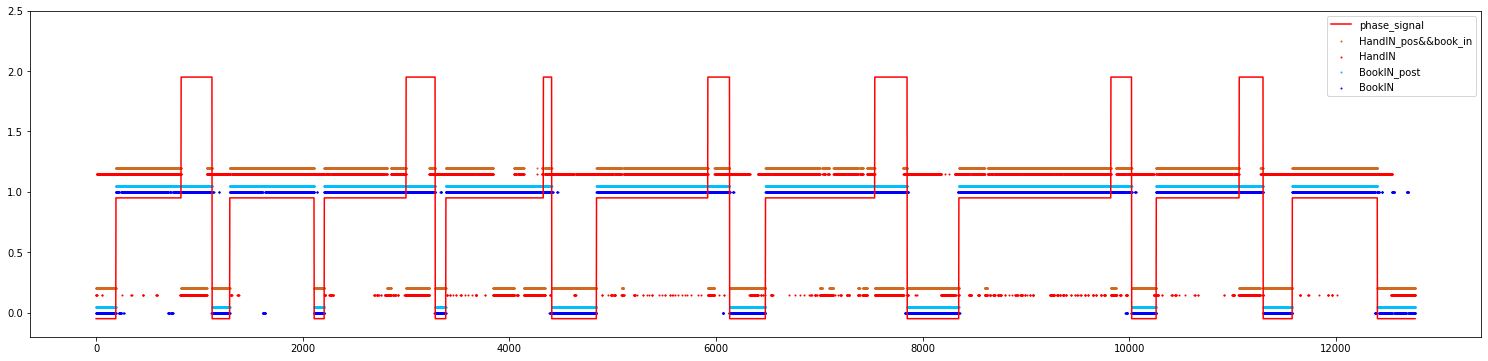

In [6]:
# Cut video and generate report
# Get cutting points, book signal 1->0
signal_book_v1 = signal_book_v1.astype(np.int)

# Find signal shift, t0 - t1
cut_signal = (signal_book_v1.squeeze()[:-1] - signal_book_v1.squeeze()[1:])
# Cut frame indices
print(set(list(cut_signal)))
# Find book_in signal fall points
cut_points = np.array(np.where(cut_signal==1)) + 1

cut_points = sorted(list(set(cut_points.squeeze())))
# End is the beginning of next cycle
start_cycle_points = cut_points.copy()
start_cycle_points.insert(0, 0)

print('Cut points: ', cut_points)
print('Start cycle points: ', start_cycle_points)
# Find book_in signal rise points
piece_enter_points = np.array(np.where(cut_signal==-1)) + 1
piece_enter_points = sorted(list(set(piece_enter_points.squeeze())))
print('piece_enter_points: ', piece_enter_points)


# last time hand enter ROI before book is away, does not count into reading phase 
from collections import defaultdict
cycle_event_dict = defaultdict(list)
piece_enter_index = 0
for cycle_begin, cycle_end in zip(start_cycle_points, cut_points):
    # print(cycle_begin, cycle_end)
    # if piece_enter_index >= len(piece_enter_points):
    #     cycle_event_dict[(cycle_begin, cycle_end)] = []
    #     continue
    while piece_enter_index < len(piece_enter_points) and cycle_begin <= piece_enter_points[piece_enter_index] < cycle_end:
        cycle_event_dict[(cycle_begin, cycle_end)].append(piece_enter_points[piece_enter_index])
        piece_enter_index += 1
        
# Safe check
for cycle in cycle_event_dict:
    assert len(cycle_event_dict[cycle]) == 1

signal_hand_v1 = signal_hand_v1.squeeze().astype(np.int)
phase_signal = np.zeros_like(signal_hand_v1)
for cycle, piece_enter_indexs in cycle_event_dict.items():
    # print(cycle, piece_enter_indexs)
    phase_signal[piece_enter_indexs[0]:cycle[1]] =  1

# pre_idle  ----   working  ----  post_idle
for cycle in cycle_event_dict:
    cycle_len = cycle[1] - cycle[0]
    hand_idx = cycle[1]
    # Find latest hand_enter_signal
    # print(' phase: ', cycle, hand_idx)
    # print(signal_hand_v1[hand_idx-1] , signal_hand_v1[hand_idx] )
    while hand_idx>0 and signal_hand_v1[hand_idx-1] - signal_hand_v1[hand_idx] != -1:
        hand_idx -= 1
    # print('Latest hand enter index ', hand_idx)
    if cycle[1] - hand_idx < cycle_len*0.33:
        while signal_hand_v1[hand_idx-1]==0:
            hand_idx-=1
        phase_signal[hand_idx:cycle[1]] = 2 # Mark as post_idle

fig = plt.figure(figsize=(26,6))
plt.scatter(np.arange(seq_len), signal_hand_v1+0.2, c='chocolate', s=1, label='HandIN_pos&&book_in')
plt.scatter(np.arange(seq_len), np.array(signal['signal_hand'])+0.15, c='r', s=1, label='HandIN')

plt.scatter(np.arange(seq_len), signal_book_v1+0.05, c='deepskyblue', s=1, label='BookIN_post')
plt.scatter(np.arange(seq_len), np.array(signal['signal_book'])<0.5, c='b', s=1, label='BookIN')

plt.plot(np.arange(seq_len), phase_signal-0.05, c='red', label='phase_signal')

plt.ylim([-0.2, 2.5])
plt.legend(loc='upper right')
plt.show()


In [7]:
for cycle_begin, cycle_end in zip(start_cycle_points, cut_points):
    print(cycle_begin, cycle_end)

0 1122
1122 2110
2110 3282
3282 4410
4410 6132
6132 7851
7851 10024
10024 11297
11297 12403


In [8]:

import os
out_dir = './cut_clips/'
os.makedirs(out_dir, exist_ok=True)
vid_file = './res.mp4'
fin = cv2.VideoCapture(vid_file)

frame_idx = 0
vid_idx = 0
fout = cv2.VideoWriter(f'{out_dir}{vid_idx:04d}.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (640, 360))
while frame_idx < seq_len:
    ret, im = fin.read()
    print(f'Video {vid_idx}, frame {frame_idx}', end='\r')
    if ret:
        if frame_idx in cut_points:
            fout.release()
            vid_idx += 1
            fout = cv2.VideoWriter(f'{out_dir}{vid_idx:04d}.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (640, 360))
            print('New clip \n')
        fout.write(im)
        frame_idx += 1
    else:
        assert frame_idx==seq_len
        break

fin.release()
fout.release()

# for vid_i, cut_p in enumerate(cut_points):


New clip frame 1122

New clip frame 2110

New clip frame 3282

New clip frame 4410



KeyboardInterrupt: 

False
0


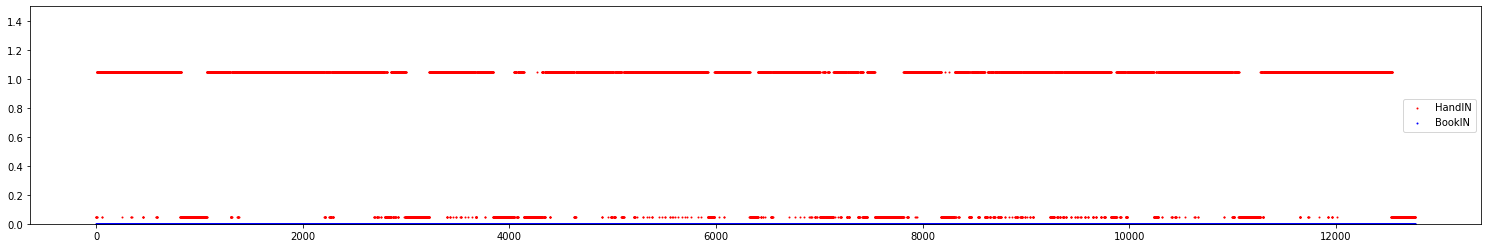

In [9]:
import cv2
# Close some temporal holes in BookNotIn signal
signal_book_v1 = 1-cv2.morphologyEx(1-np.array(signal['signal_book']).astype(np.uint8), cv2.MORPH_CLOSE, np.ones(21, np.uint8))
signal_book_v1 = 1-cv2.erode(1-signal_book_v1, np.ones(29, np.uint8))
print(np.all(signal_book_v1==signal['signal_book']))
segments, _ = cv2.findContours(signal_book_v1, cv2.RETR_LIST,  cv2.CHAIN_APPROX_NONE)
print(len(segments))
seq_len = len(signal['signal_hand'])
fig = plt.figure(figsize=(26,4))
plt.scatter(np.arange(seq_len), np.array(signal['signal_hand'])+0.05, c='r', s=1, label='HandIN')
plt.scatter(np.arange(seq_len), signal_book_v1, c='b', s=1, label='BookIN')
plt.ylim([0, 1.5])
plt.legend(loc='center right')
plt.show()


# Signal filtering methods
* Accurate item signal is more important. 
    - Filtering false positive, due to hand occlusion
    - Filtering false negative, very rare
    

In [ ]:
# with widgets.Output() as w:
#     seq_len = len(signal['signal_hand'])
#     fig = plt.figure(figsize=(26,4))
#     plt.scatter(np.arange(seq_len), signal['signal_hand']+0.1, c='r', s=1, label='HandIN')
#     plt.scatter(np.arange(seq_len), signal['signal_book'], c='b', s=1, label='BookIN')
#     plt.ylim([-0.5, 1.5])
#     plt.legend(loc='center right')
#     display(fig)


<Figure size 1872x288 with 0 Axes>

In [10]:
from typing import List
def draw_video(vid_file, book_signal:List[int]=None, hand_signal:List[int]=None, suffix='post'):
    out_file = vid_file[:-4] + '_' + suffix + vid_file[-4:]
    red, green = np.tile([[[0,0, 255]]], [360, 640, 1]), np.tile([[[0,255,0]]], [360, 640, 1])
    frame_idx = 0
    fin = cv2.VideoCapture(vid_file)
    fout = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc('M','J','P','G'), 30, (640, 360)) 
        
    ret = True
    while ret:
        print(f'Frame index {frame_idx}', end='\r')
        ret, im = fin.read()
        if ret:
            if book_signal is not None:
                mask = red if book_signal[frame_idx]==0 else green
                im = mask*0.3 + im*0.7
                im = im.astype(np.uint8)
            fout.write(im)
            frame_idx += 1
        # if frame_idx == 300: # Debug helper
        #     break
    fin.release()
    fout.release()
    return

def draw_phase_video(vid_file, signal:List[int]=None, suffix='post'):

    # # Pre_idel (blue): 3, 252, 248
    # # Working  (red):  252, 3, 57
    # # Post_idle(green): 3, 252, 44
    # pre_idle_color = 
    out_file = vid_file[:-4] + '_' + suffix + vid_file[-4:]
    pre_idle_color, working_color, post_idle_color= np.tile([[[248, 252, 3]]], [360, 640, 1]), np.tile([[[57,3,252]]], [360, 640, 1]), np.tile([[[44, 252, 3]]], [360, 640, 1])
    frame_idx = 0
    frame_idx = 0
    fin = cv2.VideoCapture(vid_file)
    fout = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc('M','J','P','G'), 30, (640, 360)) 
        
    ret = True
    while ret:
        print(f'Frame index {frame_idx}', end='\r')
        ret, im = fin.read()
        if ret:
            if signal is not None:
                mask = None
                if signal[frame_idx] == 0:
                    mask = pre_idle_color
                if signal[frame_idx] == 1:
                    mask = working_color
                if signal[frame_idx] == 2:
                    mask = post_idle_color        
                im = mask*0.3 + im*0.7
                im = im.astype(np.uint8)
            fout.write(im)
            frame_idx += 1
        # if frame_idx == 300: # Debug helper
        #     break
    fin.release()
    fout.release()
    return



In [ ]:
draw_video('./res.mp4', book_signal=signal_book_v1)
draw_phase_video('./res.mp4', signal=phase_signal)

In [ ]:
# simple analysis of phase signal
np.savetxt('phase_signal.csv', phase_signal, fmt='%i', delimiter=',')

In [11]:
!python -m pip install pandas plotly kaleido -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



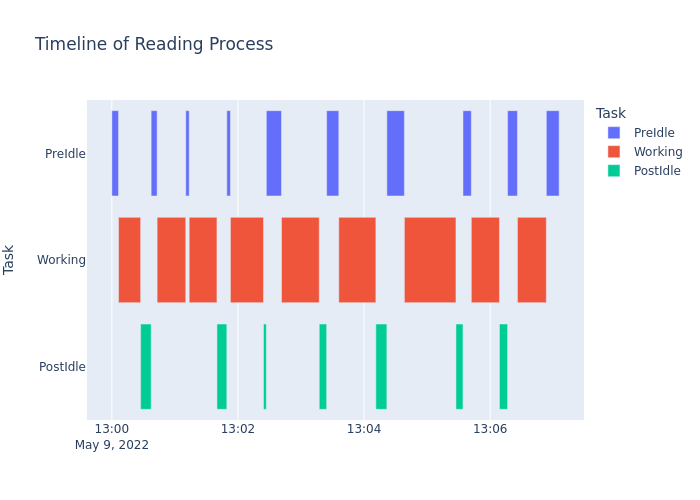

In [13]:
import pandas as pd 
FPS = 30. 
data = pd.DataFrame(phase_signal, columns=['phase'])
data = data.reset_index() 

data['time_s'] = data['index']/FPS 
data['time'] = pd.to_timedelta(data['time_s'], unit='s') + pd.Timestamp(2022,5,9,13) 
# Get Gantt Chart raw data 
data['phase_change'] = data['phase'].diff() 
change = data[data['phase_change'] != 0] 
final_end_time = data.iloc[-1]['time'] + pd.to_timedelta(1/FPS, unit='s') 
# print(end_time) 
phase_code = {0:'PreIdle', 1:'Working', 2:'PostIdle'} 
change['phase_str'] = change['phase'].map(phase_code) 
 
res = [] 
for i in range(len(change)): 
    start = change.iloc[i]['time'] 
    if i==len(change)-1: 
        end_time = final_end_time 
    else: 
        end_time = change.iloc[i+1]['time'] 
    res.append(dict(Task=change.iloc[i]['phase_str'], Start=start, Finish=end_time)) 
 
  
phase_colors = {'PreIdle': '#636EFA', 
          'Working': '#EF553B', 
          'PostIdle': '#00CC96'} 

# phase_colors = {'PreIdle': 'lightblue', 
#           'Working': 'red', 
#           'PostIdle': 'green'} 
 
import kaleido
import plotly.express as px
# plotly.offline.init_notebook_mode(connected=True)

fig = px.timeline(res, x_start='Start', x_end='Finish', y='Task', color='Task', 
    color_discrete_map=phase_colors, title='Timeline of Reading Process')
fig.show('png') 
fig.write_image('./data/timeline_chart.png')
 

In [14]:
res_df = pd.DataFrame(res)
res_df['Time'] = (res_df.Finish - res_df.Start).dt.total_seconds()
res_df.to_csv('phase_gantt.csv')
# Remove first and last phase to ensure the stats are meaningful
res_df = res_df.iloc[1:-1]
phase_time_avg = res_df.groupby('Task')['Time'].mean().reset_index()

fig = px.pie(phase_time_avg, values='Time', names='Task', color='Task', color_discrete_map=phase_colors, title='Average phase time of book reading')
fig.update_traces(hoverinfo='label+percent', texttemplate="%{value:.3f}s <br>(%{percent})")
fig.show()
fig.write_image('./data/pie_chart.png')

phase_time_avg

,Task,Time
0,PostIdle,7.719048
1,PreIdle,9.050000
2,Working,31.181481
